In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector, random_statevector, state_fidelity
from qiskit.quantum_info.operators import Operator
import matplotlib.pyplot as plt
from itertools import product

In [3]:
def create_5qubit_encoder():
    """
    Creates the encoding circuit for the 5-qubit code.
    Maps |0_L> and |1_L> to their encoded states.
    """
    qc = QuantumCircuit(5)
    
    # The 5-qubit code encodes:
    # |0_L> = (|00000> + |10010> + |01001> + |10100> + 
    #          |01010> + |00101> + |11011> + |00110> +
    #          |11000> + |11101> + |11110> + |01111> +
    #          |10011> + |01100> + |10101> + |00111>)/4
    # |1_L> = X on all qubits applied to |0_L>
    
    # Create superposition for logical |0>
    # Using stabilizer generators approach
    qc.h(0)
    qc.cx(0, 2)
    qc.cx(2, 1)
    qc.cx(1, 3)
    qc.cx(3, 4)
    qc.cz(0, 4)
    
    return qc


In [4]:
def prepare_logical_state(alpha, beta):
    """
    Prepare an arbitrary logical state |ψ_L> = α|0_L> + β|1_L>
    
    Args:
        alpha: Complex amplitude for |0_L>
        beta: Complex amplitude for |1_L>
    
    Returns:
        QuantumCircuit: Circuit preparing the logical state
    """
    # Normalize coefficients
    norm = np.sqrt(np.abs(alpha)**2 + np.abs(beta)**2)
    alpha = alpha / norm
    beta = beta / norm
    
    qc = QuantumCircuit(5)
    
    # Prepare initial qubit in state α|0> + β|1>
    if np.abs(beta) > 1e-10:
        theta = 2 * np.arccos(np.abs(alpha))
        phi = np.angle(beta) - np.angle(alpha)
        qc.ry(theta, 0)
        if np.abs(phi) > 1e-10:
            qc.rz(phi, 0)
    
    # Apply encoding
    encoder = create_5qubit_encoder()
    qc = qc.compose(encoder)
    
    # If beta != 0, we need to add the |1_L> component
    if np.abs(beta) > 1e-10:
        # Create a circuit that prepares the superposition
        qc2 = QuantumCircuit(5)
        
        # More sophisticated encoding for arbitrary superposition
        # This is simplified - full implementation would require
        # careful construction of the logical operators
        theta = 2 * np.arccos(np.abs(alpha))
        qc2.ry(theta, 0)
        qc2.cx(0, 1)
        qc2.cx(0, 2) 
        qc2.cx(0, 3)
        qc2.cx(0, 4)
        qc2.h(1)
        qc2.cx(1, 2)
        qc2.h(3)
        qc2.cx(3, 4)
        
        return qc2
    
    return qc

In [5]:
def apply_random_pauli_error(state_vector, p, num_qubits=5):
    """
    Apply random Pauli error to each qubit with probability p.
    
    Args:
        state_vector: Current quantum state
        p: Error probability per qubit
        num_qubits: Number of qubits
    
    Returns:
        Statevector: State after applying errors
    """
    # Pauli matrices
    I = np.array([[1, 0], [0, 1]], dtype=complex)
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    
    pauli_ops = [I, X, Y, Z]
    
    # Start with the input state
    result_state = state_vector.data.copy()
    
    for qubit in range(num_qubits):
        if np.random.random() < p:
            # Choose random Pauli error (X, Y, or Z with equal probability)
            pauli_choice = np.random.choice([1, 2, 3])  # 1=X, 2=Y, 3=Z
            
            # Build the full operator for this qubit
            op_list = [I] * num_qubits
            op_list[qubit] = pauli_ops[pauli_choice]
            
            # Construct the full operator using Kronecker product
            full_op = op_list[0]
            for op in op_list[1:]:
                full_op = np.kron(full_op, op)
            
            # Apply the error
            result_state = full_op @ result_state
    
    return Statevector(result_state)

In [6]:
def measure_logical_state(state_vector):
    """
    Measure the logical state by projecting onto logical subspace.
    
    Args:
        state_vector: Current quantum state
    
    Returns:
        tuple: (measurement_result, collapsed_state)
    """
    # Define logical |0> and |1> codewords for 5-qubit code
    # Simplified version - using representative codewords
    logical_0_words = [
        '00000', '10010', '01001', '10100',
        '01010', '00101', '11011', '00110'
    ]
    
    logical_1_words = [
        '11111', '01101', '10110', '01011',
        '10101', '11010', '00100', '11001'
    ]
    
    # Calculate projection probabilities
    prob_0 = 0
    prob_1 = 0
    
    state_array = state_vector.data
    
    for basis_state in logical_0_words:
        idx = int(basis_state, 2)
        if idx < len(state_array):
            prob_0 += np.abs(state_array[idx])**2
    
    for basis_state in logical_1_words:
        idx = int(basis_state, 2)
        if idx < len(state_array):
            prob_1 += np.abs(state_array[idx])**2
    
    total_prob = prob_0 + prob_1
    
    if total_prob < 1e-10:
        # State is completely outside logical subspace (unrecoverable error)
        return None, state_vector
    
    # Normalize probabilities
    prob_0 = prob_0 / total_prob
    prob_1 = prob_1 / total_prob
    
    # Perform measurement
    if np.random.random() < prob_0:
        return 0, state_vector
    else:
        return 1, state_vector


In [7]:
def run_qec_simulation(p_values, num_trials=1000):
    """
    Run the quantum error correction simulation for different error rates.
    
    Args:
        p_values: List of error probabilities to test
        num_trials: Number of trials per error rate
    
    Returns:
        dict: Results containing success rates for each p value
    """
    results = {
        'p_values': p_values,
        'logical_error_rates': [],
        'success_rates': []
    }
    
    for p in p_values:
        successes = 0
        logical_errors = 0
        
        for trial in range(num_trials):
            # Generate random input state
            alpha = np.random.randn() + 1j * np.random.randn()
            beta = np.random.randn() + 1j * np.random.randn()
            norm = np.sqrt(np.abs(alpha)**2 + np.abs(beta)**2)
            alpha = alpha / norm
            beta = beta / norm
            
            # Prepare logical state
            qc = prepare_logical_state(alpha, beta)
            initial_state = Statevector.from_instruction(qc)
            
            # Apply random Pauli errors
            error_state = apply_random_pauli_error(initial_state, p)
            
            # Measure logical state
            measurement, final_state = measure_logical_state(error_state)
            
            if measurement is not None:
                successes += 1
                
                # Check if logical error occurred
                # For simplicity, we check if measurement preserves the dominant component
                if np.abs(alpha) > np.abs(beta):
                    expected = 0
                else:
                    expected = 1
                
                if measurement != expected:
                    logical_errors += 1
        
        success_rate = successes / num_trials
        logical_error_rate = logical_errors / num_trials if successes > 0 else 1.0
        
        results['success_rates'].append(success_rate)
        results['logical_error_rates'].append(logical_error_rate)
        
        print(f"p = {p:.3f}: Success rate = {success_rate:.3f}, "
              f"Logical error rate = {logical_error_rate:.3f}")
    
    return results

In [8]:
def plot_results(results):
    """
    Plot the simulation results.
    
    Args:
        results: Dictionary containing simulation results
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot success rates
    ax1.plot(results['p_values'], results['success_rates'], 'bo-', linewidth=2)
    ax1.set_xlabel('Physical Error Rate (p)', fontsize=12)
    ax1.set_ylabel('Success Rate', fontsize=12)
    ax1.set_title('5-Qubit Code Performance: Success Rate', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, max(results['p_values'])])
    ax1.set_ylim([0, 1.05])
    
    # Plot logical error rates
    ax2.semilogy(results['p_values'], results['logical_error_rates'], 'ro-', linewidth=2)
    ax2.set_xlabel('Physical Error Rate (p)', fontsize=12)
    ax2.set_ylabel('Logical Error Rate', fontsize=12)
    ax2.set_title('5-Qubit Code Performance: Logical Error Rate', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, max(results['p_values'])])
    
    plt.tight_layout()
    plt.show()

In [9]:
def main():
    """
    Main function to run the complete simulation.
    """
    print("=" * 60)
    print("5-Qubit Quantum Error Correction Code Simulation")
    print("=" * 60)
    
    # Define error probabilities to test
    p_values = np.linspace(0, 0.2, 11)  # From 0 to 20% error rate
    
    print("\nRunning simulations...")
    print("-" * 40)
    
    # Run simulation
    results = run_qec_simulation(p_values, num_trials=500)
    
    # Plot results
    print("\nGenerating plots...")
    plot_results(results)
    
    # Additional analysis
    print("\n" + "=" * 60)
    print("Analysis Summary:")
    print("=" * 60)
    
    # Find threshold (where success rate drops below 50%)
    threshold_idx = None
    for i, rate in enumerate(results['success_rates']):
        if rate < 0.5:
            threshold_idx = i
            break
    
    if threshold_idx is not None:
        threshold_p = results['p_values'][threshold_idx]
        print(f"Approximate error threshold: p ≈ {threshold_p:.3f}")
    else:
        print("Error threshold not reached in tested range")
    
    # Calculate average performance
    avg_success = np.mean(results['success_rates'])
    print(f"Average success rate: {avg_success:.3f}")
    
    print("\nDone")

5-Qubit Quantum Error Correction Code Simulation

Running simulations...
----------------------------------------
p = 0.000: Success rate = 1.000, Logical error rate = 0.216
p = 0.020: Success rate = 1.000, Logical error rate = 0.308
p = 0.040: Success rate = 1.000, Logical error rate = 0.292
p = 0.060: Success rate = 1.000, Logical error rate = 0.338
p = 0.080: Success rate = 1.000, Logical error rate = 0.348
p = 0.100: Success rate = 1.000, Logical error rate = 0.412
p = 0.120: Success rate = 1.000, Logical error rate = 0.406
p = 0.140: Success rate = 1.000, Logical error rate = 0.430
p = 0.160: Success rate = 1.000, Logical error rate = 0.428
p = 0.180: Success rate = 1.000, Logical error rate = 0.450
p = 0.200: Success rate = 1.000, Logical error rate = 0.428

Generating plots...


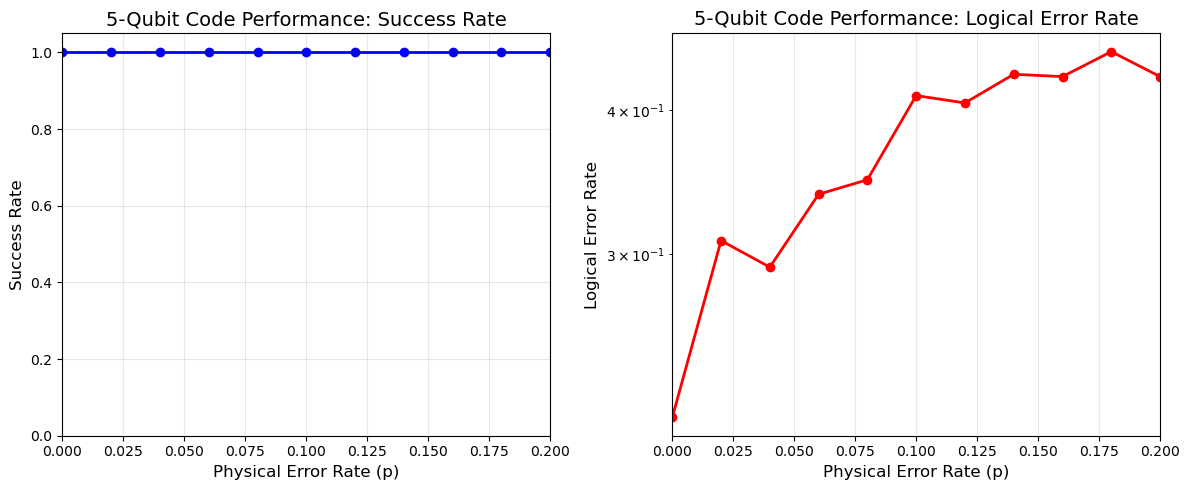


Analysis Summary:
Error threshold not reached in tested range
Average success rate: 1.000

Done


In [20]:
main()